# Air Pressure System Failure Challenge
data from: [here](https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks)

scores to beat: 

Camila F. Costa and Mario A. Nascimento | 9920 | 542 | 9 

Christopher Gondek, Daniel Hafner and Oliver R. Sampson | 10900 | 490 | 12 

Sumeet Garnaik, Sushovan Das, Rama Syamala Sreepada and Bidyut Kr. Patra | 11480 | 398 | 15 

## The Problem

The Air Pressure system (APS) which generates pressurised air that are utilized in various functions in a truck, such as braking and gear changes. Malfunction of the APS is costly as it renders the truck stranded immediatly, leading to costly delays and towing operations. 

Scheduled preventative maintainance is historically the main tool to combat this. It is however costly and impractical to sample the entire fleet to prevent malfunctions. With the array of sensor data availabe to assess the performance and operating conditions of the APS however, we can attempt to predict imminent systems failure leading to more efficient resource allocation.

In [248]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno

import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import make_scorer, confusion_matrix, plot_confusion_matrix, classification_report

In [208]:
df_train = pd.read_csv("aps_failure_training_set.csv")

In [39]:
df_test = pd.read_csv("aps_failure_test_set.csv")

In [3]:
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [209]:
# set na to proper NaNs for later imputation
df_train.replace("na", np.nan, inplace=True)
df_test.replace("na", np.nan, inplace=True)

# encode class
df_train['class'].replace(['pos','neg'],[1,0], inplace=True)
df_test['class'].replace(['pos','neg'],[1,0], inplace=True)

# change dtypes to numbers
df_train = df_train.astype(np.float64)
df_test = df_test.astype(np.float64)

# remove features with 0 variance straight away
# df_train = df_train.loc[:,df_train.apply(pd.Series.nunique) != 1]

# drop duplicates
# df_train = df_train.drop_duplicates()
# df_train = df_train.T.drop_duplicates().T


In [210]:
# check for class imbalance
df_train["class"].value_counts(normalize=True)

0.0    0.983333
1.0    0.016667
Name: class, dtype: float64

<AxesSubplot:>

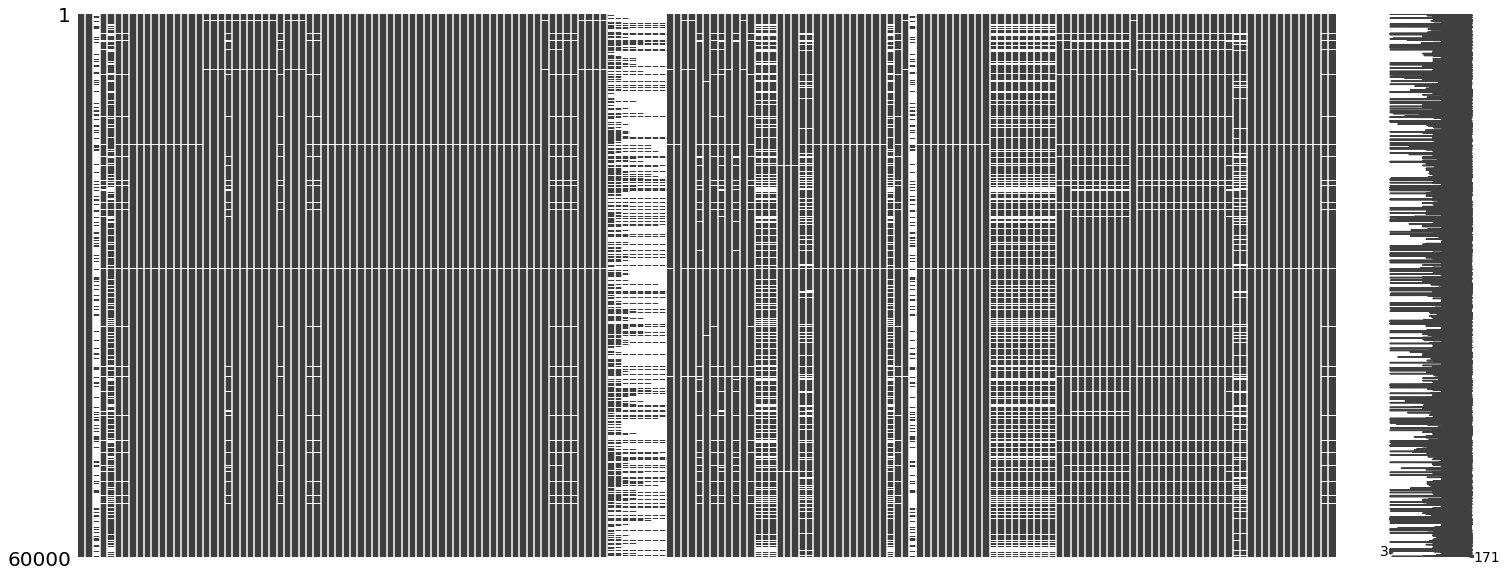

In [211]:
# checking for nullity
missingno.matrix(df_train)

In [120]:
# # drop any column with over 50 % values missing
# # percent_rows_not_nan = 0.5
# # mask = (pd.isna(df_train).sum() <= len(df_train) * percent_rows_not_nan).values

# # df_train_drop = df_train.loc[:, mask].copy()
# # print(f"{np.around((1 - len(df_train_drop.columns) / len(df_train.columns)) * 100, 2)} % of columns dropped.")

# # drop any row with over 50 % values missing
# # percent_cols_not_nan = 0.5
# # tresh_columns = np.floor(len(df_train.columns) * percent_cols_not_nan).astype(int)

# df_train_drop.dropna(thresh=tresh_columns, inplace=True)
# print(f"{np.around((1 - len(df_train_drop) / len(df_train)) * 100, 2)} % of rows dropped.")

# # reset index
# df_train.reset_index(drop=True, inplace=True)

4.71 % of columns dropped.
0.7 % of rows dropped.


<AxesSubplot:>

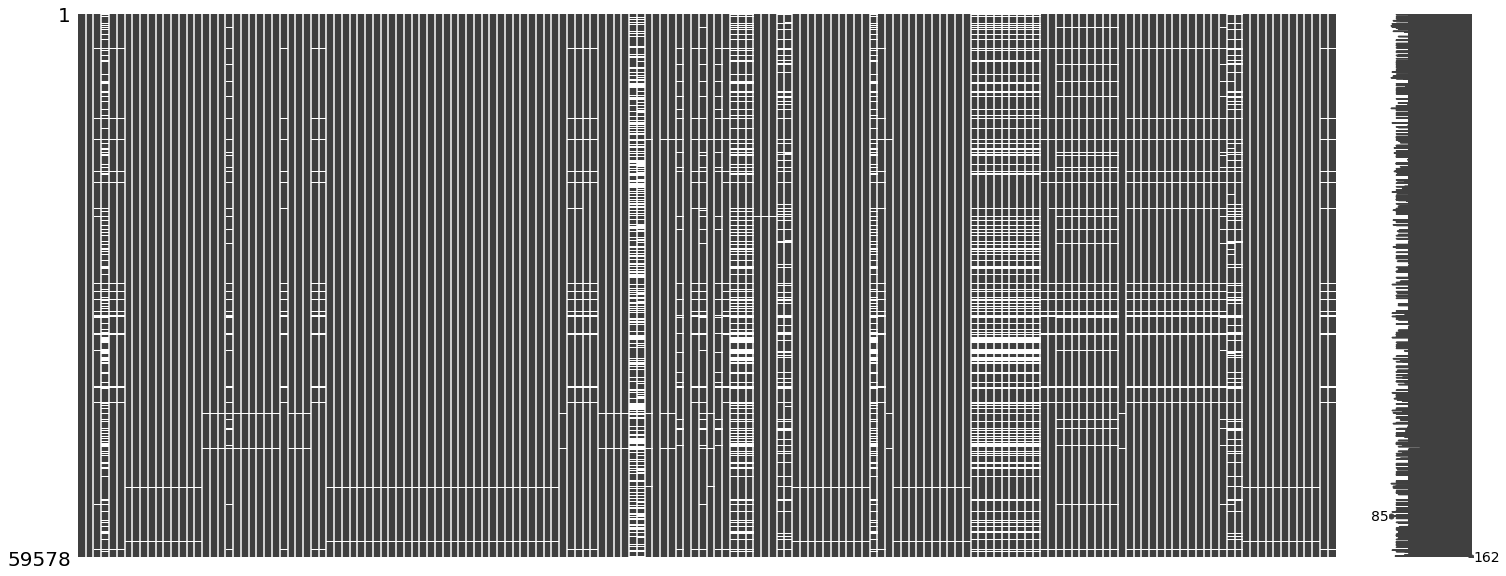

In [212]:
missingno.matrix(df_train_drop)

In [217]:
# check class imbalance after pre-preprocessing
df_train["class"].value_counts()

0.0    59000
1.0     1000
Name: class, dtype: int64

In [11]:
# def evaluator(y_true, y_pred_proba):
#     p_to_try = np.linspace(0.5, 1, 51)
#     score_lst = []

#     for p in p_to_try:
#         y_pred = []
#         for i in y_pred_proba:
#             if i >= p:
#                 y_pred.append(1)
#             else:
#                 y_pred.append(0)
#         cm = confusion_matrix(y_true, y_pred)
#         score = (cm[0, 1] * 10 + cm[1, 0] * 500) / len(y_true) # FP + FN
#         score_lst.append(score)    

#     return min(score_lst)

# scorer = make_scorer(evaluator, greater_is_better=False, needs_proba=True)

In [41]:
def evaluator(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return (cm[0, 1] * 10 + cm[1, 0] * 500) # FP + FN

scorer = make_scorer(evaluator, greater_is_better=False)

In [40]:
def evaluator_norm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return (cm[0, 1] * 10 + cm[1, 0] * 500) / len(y_true) # FP + FN

scorer_norm = make_scorer(evaluator_norm, greater_is_better=False)

In [124]:
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [236]:
target_var = "class"
y = df_train[target_var]
X = df_train.drop(target_var, axis=1)

y_test = df_test[target_var]
X_test = df_test.drop(target_var, axis=1)

-187500

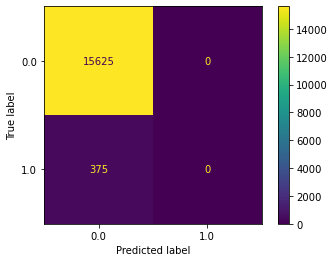

In [244]:
# dummy classifier for doing nothing
no_action = DummyClassifier(strategy="most_frequent", random_state=42)

no_action.fit(X, y)
y_dummy_pred = no_action.predict(X)


plot_confusion_matrix(no_action, X_test, y_test)
scorer(no_action, X_test, y_test)

-185440

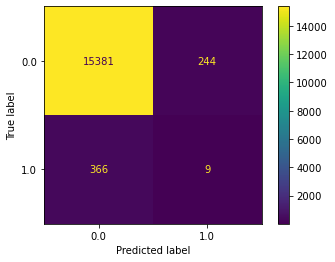

In [243]:
# dummy classifier for randomly checking a truck
guess = DummyClassifier(strategy="stratified", random_state=42)

guess.fit(X, y)
y_dummy_pred = guess.predict(X)


plot_confusion_matrix(guess, X_test, y_test)
scorer(guess, X_test, y_test)


In [127]:
classifiers = [
    LogisticRegression(max_iter=1_000)
    , DecisionTreeClassifier()
    , RandomForestClassifier()
    , SVC()
    , KNeighborsClassifier()
    , GaussianNB()
    , MLPClassifier()
]

impute = SimpleImputer(strategy="median")
over = RandomOverSampler(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

def producer(clf):
    pipe = make_pipeline(under, impute, StandardScaler(), clf)

    search = GridSearchCV(pipe, {}, scoring=scorer_norm, n_jobs=-1, cv=StratifiedKFold())

    search.fit(X, y)

    return (str(clf), search.best_score_, search.refit_time_)

clf_perf = joblib.Parallel(n_jobs=-1)(joblib.delayed(producer)(clf) for clf in classifiers)

# clf_perf = []
# for clf in classifiers:
#     clf_perf.append(producer(clf))

scores = pd.DataFrame(clf_perf, columns=["clf", "score", "time"])
scores.sort_values(by="score", inplace=True)

/Users/ivenwinkelmann/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ivenwinkelmann/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ivenwinkelmann/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ivenwinkelmann/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  war

In [128]:
scores

,clf,score,time
1,DecisionTreeClassifier(),-1.257342,2.395137
5,GaussianNB(),-1.241230,0.723579
4,KNeighborsClassifier(),-1.155628,0.140974
3,SVC(),-1.052066,0.429345
0,LogisticRegression(max_iter=1000),-1.013294,1.358704
6,MLPClassifier(),-0.904358,4.268836
2,RandomForestClassifier(),-0.778639,2.180014


In [93]:
# test over/under sampling
over = RandomOverSampler(sampling_strategy=0.1, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

over_under = make_pipeline(over, under)

X_res, y_res = over_under.fit_resample(X, y)

print(len(pd.concat((X_res, y_res), axis=1)))
pd.concat((X_res, y_res), axis=1)["class"].value_counts()

17574


0.0    11716
1.0     5858
Name: class, dtype: int64

In [237]:
# select features
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42, replacement=True)
impute = SimpleImputer(strategy="median")
clf = RandomForestClassifier(n_estimators=48, n_jobs=-1)
selector = RFECV(clf, cv=StratifiedKFold(), scoring=scorer_norm, min_features_to_select=10, step=2)

selector_pipe = make_pipeline(impute, under, selector)

selector_pipe.fit(X, y)

feature_mask = selector_pipe[2].support_

In [238]:
len(feature_mask)

170

In [239]:
# set up pipeline

impute = SimpleImputer(strategy="median")
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42, replacement=True)
clf = RandomForestClassifier(n_jobs=-1, random_state=42)

pipe = make_pipeline(under, impute, clf)

search_rf = GridSearchCV(pipe, {}, scoring=scorer, cv=StratifiedKFold())

search_rf.fit(X.loc[:,feature_mask], y)

print(search_rf.best_score_)

-9536.0


In [184]:
# tune hyperparameters
impute = SimpleImputer(strategy="median")
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42, replacement=True)
clf = RandomForestClassifier(n_jobs=-1, random_state=42, warm_start=True)

pipe = make_pipeline(under, impute, clf)

param_grid = {
    "randomforestclassifier__n_estimators": np.around(np.linspace(10, 500, 20),0).astype(int)
    , "randomforestclassifier__min_samples_leaf": np.arange(1, 5)
}

hyper_search = HalvingGridSearchCV(pipe, param_grid, scoring=scorer_norm, cv=StratifiedKFold())

hyper_search.fit(X.loc[:,feature_mask], y)

print(hyper_search.best_score_)
print(hyper_search.best_params_)

-0.7684921704116365
{'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 87}


In [240]:
y_pred = search_rf.predict(X.loc[:, feature_mask])

evaluator(y, y_pred)

24100

In [241]:
# find the probablity treshold that gives the best score
y_pred_proba = search_rf.predict_proba(X.loc[:, feature_mask])

score_lst = []
p_to_try = np.linspace(0.5, 1, 51)

for p in p_to_try:
    y_pred = []
    for i in y_pred_proba[:, 1]:
        if i >= p:
            y_pred.append(1)
        else:
            y_pred.append(0)
    score_lst.append(evaluator(y, y_pred))
    
pd.DataFrame(list(zip(p_to_try, score_lst)), columns=["p", "score"]).sort_values(by="score")


,p,score
13,0.63,21100
16,0.66,21120
15,0.65,21160
14,0.64,21190
11,0.61,21220
12,0.62,21250
17,0.67,21650
9,0.59,21690
8,0.58,21710
7,0.57,21710


In [246]:
y_pred_proba = search_rf.predict_proba(X_test.loc[:, feature_mask])

p = 0.5

y_pred = []
for i in y_pred_proba[:, 1]:
    if i >= p:
        y_pred.append(1)
    else:
        y_pred.append(0)
evaluator(y_test, y_pred)

10300

In [253]:
len(df_test)

16000

In [252]:
scorer(no_action, X_test, y_test) * 1000

-187500000

In [247]:
confusion_matrix(y_test, y_pred)

array([[14995,   630],
       [    8,   367]])

In [249]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     15625
         1.0       0.37      0.98      0.53       375

    accuracy                           0.96     16000
   macro avg       0.68      0.97      0.76     16000
weighted avg       0.98      0.96      0.97     16000



In [250]:
print(classification_report(y_test, no_action.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     15625
         1.0       0.00      0.00      0.00       375

    accuracy                           0.98     16000
   macro avg       0.49      0.50      0.49     16000
weighted avg       0.95      0.98      0.96     16000



/Users/ivenwinkelmann/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ivenwinkelmann/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ivenwinkelmann/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r